In [1]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split



/home/acamargofb/anaconda3/envs/pytorch_cuda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/acamargofb/anaconda3/envs/pytorch_cuda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:


# Paths to the dataset and annotations
img_path = "/media/acamargofb/easystore/ArtificialIntelligence/SegementationFootballplayer/archive/images/"
annotations_path = "/media/acamargofb/easystore/ArtificialIntelligence/SegementationFootballplayer/archive/annotations/instances_default.json"

INPUT_SIZE = (1920, 1080)  # Original image size
IMG_SIZE = 512  # Resized image size for the model
N = 512  # Number of images

# Load the JSON annotation file
with open(annotations_path) as f:
    annotations = json.load(f)



In [3]:
image_id_dict = {image['id']: image['file_name'] for image in annotations['images']}

In [4]:
# Initialize an array to store the masks
masks = np.zeros((N, IMG_SIZE, IMG_SIZE), dtype=bool)

# Process all annotations to generate masks
for annotation in annotations['annotations']:
    img_id = annotation['image_id']
    
    # Create a blank mask
    mask = Image.new('1', INPUT_SIZE)  # '1' mode for binary image
    mask_draw = ImageDraw.Draw(mask)   # Draw object to draw the polygons
    
    # Draw the segmentation polygons on the mask
    for segmentation in annotation['segmentation']:
        polygon = np.array(segmentation).reshape((-1, 2))  # Reshape segmentation to (x, y) pairs
        mask_draw.polygon([tuple(point) for point in polygon], fill=1)
    
    # Resize the mask to the model's input size and convert to a boolean array
    bool_array = np.array(mask.resize((IMG_SIZE, IMG_SIZE))) > 0
    masks[img_id - 1] = masks[img_id - 1] | bool_array  # Merge with any existing mask for the image

# Reshape masks to add channel dimension
masks = masks.reshape(N, IMG_SIZE, IMG_SIZE, 1)

print("Mask generation complete.")

Mask generation complete.


In [5]:
print(annotation['segmentation'])

[[164.6, 293.57, 158.7, 299.27, 157.8, 300.67, 157.8, 302.17, 159.0, 303.87, 161.5, 304.07, 172.2, 299.47, 172.6, 298.37, 171.7, 294.87, 171.3, 290.67, 174.2, 282.47, 174.9, 279.07, 175.1, 274.87, 176.1, 270.17, 178.0, 264.87, 181.5, 264.97, 182.9, 264.07, 186.3, 256.97, 191.3, 266.37, 192.4, 267.57, 193.4, 270.37, 195.7, 279.27, 197.8, 290.07, 198.3, 299.47, 198.0, 302.77, 198.4, 305.27, 200.6, 307.27, 203.4, 307.57, 205.5, 306.87, 205.3, 304.07, 203.2, 300.67, 203.1, 295.67, 202.9, 283.87, 200.7, 270.27, 201.0, 264.87, 201.4, 260.37, 200.9, 252.17, 199.6, 248.97, 199.9, 244.67, 200.1, 236.77, 198.7, 229.27, 199.4, 225.97, 200.0, 224.17, 202.0, 226.47, 206.5, 239.47, 204.3, 250.27, 204.2, 252.67, 204.4, 255.27, 204.5, 257.77, 205.5, 258.47, 207.2, 257.37, 207.9, 253.97, 208.4, 248.87, 209.3, 243.17, 209.6, 237.67, 209.3, 232.67, 204.1, 217.27, 202.2, 214.97, 198.7, 212.37, 194.4, 209.47, 195.3, 206.87, 195.7, 203.47, 195.1, 199.47, 192.4, 196.47, 188.6, 195.97, 184.5, 196.87, 180.6, 1

In [6]:
print(annotations['annotations'][0])

{'id': 1, 'image_id': 1, 'category_id': 1, 'segmentation': [[1630.5, 686.9, 1632.0, 683.6, 1633.4, 679.7, 1634.2, 676.1, 1634.2, 673.0, 1634.8, 669.8, 1634.8, 667.5, 1636.7, 665.0, 1637.6, 664.8, 1638.0, 665.9, 1639.1, 669.3, 1641.2, 673.4, 1643.5, 678.4, 1645.4, 682.1, 1648.1, 686.4, 1650.2, 688.8, 1650.9, 691.6, 1650.0, 693.9, 1647.4, 695.9, 1644.6, 697.6, 1643.9, 699.1, 1646.1, 700.1, 1650.6, 700.0, 1655.2, 699.9, 1658.5, 699.5, 1661.6, 698.5, 1662.1, 697.2, 1661.5, 694.9, 1660.7, 693.0, 1659.9, 691.7, 1659.1, 689.6, 1658.3, 687.1, 1657.1, 685.2, 1656.1, 683.1, 1654.8, 680.1, 1653.8, 676.5, 1652.6, 672.3, 1650.5, 669.2, 1649.1, 667.3, 1648.2, 664.9, 1647.5, 662.1, 1647.1, 658.5, 1647.0, 654.4, 1648.8, 649.0, 1651.0, 645.5, 1652.3, 640.6, 1652.5, 636.2, 1652.0, 631.8, 1653.1, 626.7, 1653.2, 621.6, 1654.2, 616.7, 1654.4, 611.0, 1653.8, 606.4, 1652.4, 602.7, 1648.9, 598.3, 1645.8, 596.6, 1642.4, 595.6, 1640.7, 595.0, 1640.0, 594.2, 1641.8, 591.2, 1642.3, 587.8, 1642.0, 585.6, 1640.5, 5

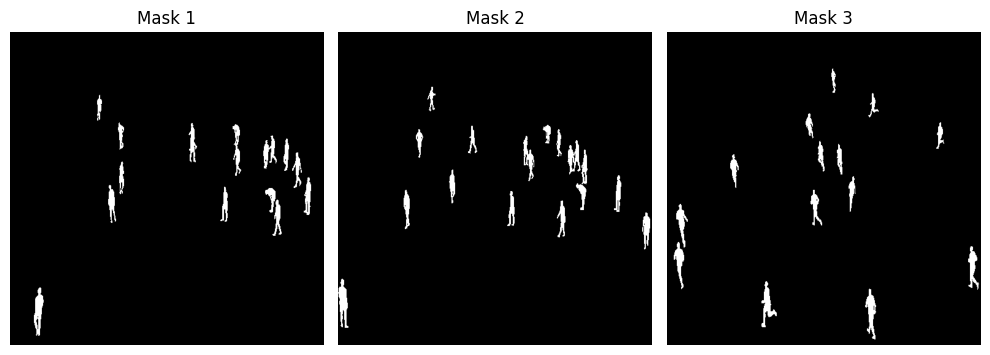

In [7]:
def visualize_masks(masks, num_masks=5):
    plt.figure(figsize=(10, 10))
    
    for i in range(num_masks):
        plt.subplot(1, num_masks, i+1)
        plt.imshow(masks[i].squeeze(), cmap='gray')  # Display mask as grayscale image
        plt.title(f"Mask {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display 5 sample masks
visualize_masks(masks, num_masks=3)


In [8]:


# Initialize an array to store the resized images
images = np.zeros((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

# Resize each image to match the input size of the model
for img_id, img_filename in image_id_dict.items():
    img = Image.open(os.path.join(img_path, img_filename))
    img = img.resize((IMG_SIZE, IMG_SIZE))
    images[img_id - 1] = img



In [9]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Contracting path (Encoder)
        self.encoder1 = self.conv_block(3, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        self.encoder5 = self.conv_block(512, 1024)  # Additional layer
        
        # Bottleneck
        self.bottleneck = self.conv_block(1024, 2048)
        
        # Expanding path (Decoder)
        self.upconv5 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.decoder5 = self.conv_block(2048, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)
        
        # Final output layer (binary segmentation)
        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )
        return block
    
    def forward(self, x):
        # Encoder (contracting path)
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.encoder3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.encoder4(F.max_pool2d(enc3, kernel_size=2))
        enc5 = self.encoder5(F.max_pool2d(enc4, kernel_size=2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc5, kernel_size=2))
        
        # Decoder (expanding path)
        dec5 = self.upconv5(bottleneck)
        dec5 = torch.cat((enc5, dec5), dim=1)
        dec5 = self.decoder5(dec5)
        dec4 = self.upconv4(dec5)
        dec4 = torch.cat((enc4, dec4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((enc3, dec3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((enc1, dec1), dim=1)
        dec1 = self.decoder1(dec1)
        
        # Final output
        return torch.sigmoid(self.conv_last(dec1))

In [10]:
# Initialize the model and move it to the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)

# Set up the loss function (Binary Cross-Entropy Loss) and the optimizer (Adam)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [11]:
class SegmentationDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images  # Image data
        self.masks = masks    # Mask data
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]  # Fetch the image
        mask = self.masks[idx]    # Fetch the corresponding mask
        
        # Convert to torch tensors
        image = torch.from_numpy(image).to(torch.float32) / 255.0  # Normalize image to [0, 1]
        mask = torch.from_numpy(mask).to(torch.float32)
        
        # Change dimension order from [H, W, C] to [C, H, W]
        image = image.permute(2, 0, 1)
        mask = mask.permute(2, 0, 1)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

# Split the data into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

# Initialize datasets and data loaders
train_dataset = SegmentationDataset(images=train_images, masks=train_masks)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = SegmentationDataset(images=val_images, masks=val_masks)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [12]:
# Function to calculate Intersection over Union (IoU)
def calculate_iou(preds, masks, threshold=0.5):
    preds = (preds > threshold).float()  # Binarize predictions
    masks = masks.float()  # Convert masks to float
    
    intersection = torch.sum(preds * masks)  # Calculate intersection
    union = torch.sum(preds) + torch.sum(masks) - intersection  # Calculate union
    
    if union == 0:
        return 0.0  # Handle cases where both prediction and mask are empty
    
    iou = intersection / union
    return iou.item()

# Function to calculate Dice Coefficient
def calculate_dice(preds, masks, threshold=0.5):
    preds = (preds > threshold).float()
    masks = masks.float()
    
    intersection = torch.sum(preds * masks)
    dice = (2 * intersection) / (torch.sum(preds) + torch.sum(masks))
    
    if torch.sum(preds) + torch.sum(masks) == 0:
        return 0.0  # Handle cases where both prediction and mask are empty
    
    return dice.item()

In [ ]:
# Number of epochs to train
num_epochs = 5

# Lists to store loss and metrics
train_loss_list = []
val_loss_list = []
iou_list = []
dice_list = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Training phase
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).float()  # Convert masks to float
        
        optimizer.zero_grad()
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, masks)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    iou_total = 0.0
    dice_total = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device).float()
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
            # Calculate IoU and Dice Coefficient
            iou = calculate_iou(outputs, masks)
            dice = calculate_dice(outputs, masks)
            
            iou_total += iou
            dice_total += dice
    
    # Calculate average losses and metrics
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_iou = iou_total / len(val_loader)
    avg_dice = dice_total / len(val_loader)
    
    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    iou_list.append(avg_iou)
    dice_list.append(avg_dice)
    
    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    print(f"IoU: {avg_iou:.4f}, Dice Coefficient: {avg_dice:.4f}")

## Separando la parte de entrenamiento y validación en dos for loops

In [13]:
# Number of epochs to train
num_epochs = 5

# Lists to store loss and metrics
train_loss_list = []
val_loss_list = []
iou_list = []
dice_list = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Training phase
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).float()  # Convert masks to float
        
        optimizer.zero_grad()
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, masks)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
    
    # Calculate average training loss
    avg_train_loss = running_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)

    # Print training summary for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {avg_train_loss:.4f}")

Epoch [1/5] Training Loss: 0.2164
Epoch [2/5] Training Loss: 0.0617
Epoch [3/5] Training Loss: 0.0218
Epoch [4/5] Training Loss: 0.0166
Epoch [5/5] Training Loss: 0.0134


In [14]:
# Validation loop
for epoch in range(num_epochs):
    model.eval()
    val_loss = 0.0
    iou_total = 0.0
    dice_total = 0.0
    
    with torch.no_grad():  # Disable gradient calculation
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device).float()
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
            # Calculate IoU and Dice Coefficient
            iou = calculate_iou(outputs, masks)
            dice = calculate_dice(outputs, masks)
            
            iou_total += iou
            dice_total += dice
    
    # Calculate average validation loss and metrics
    avg_val_loss = val_loss / len(val_loader)
    avg_iou = iou_total / len(val_loader)
    avg_dice = dice_total / len(val_loader)
    
    val_loss_list.append(avg_val_loss)
    iou_list.append(avg_iou)
    dice_list.append(avg_dice)
    
    # Print validation summary for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {avg_val_loss:.4f}, IoU: {avg_iou:.4f}, Dice Coefficient: {avg_dice:.4f}")

Epoch [1/5] Validation Loss: 0.0122, IoU: 0.7782, Dice Coefficient: 0.8751
Epoch [2/5] Validation Loss: 0.0122, IoU: 0.7782, Dice Coefficient: 0.8751
Epoch [3/5] Validation Loss: 0.0122, IoU: 0.7782, Dice Coefficient: 0.8751
Epoch [4/5] Validation Loss: 0.0122, IoU: 0.7782, Dice Coefficient: 0.8751
Epoch [5/5] Validation Loss: 0.0122, IoU: 0.7782, Dice Coefficient: 0.8751


## Guadando el modelo

In [16]:
# Save the trained model
torch.save(model.state_dict(), 'unet_football_weights.pth')


In [22]:
# Recreate the model architecture
model = UNet()  # Replace MyModelClass with your model's class

# Load the saved weights
model.load_state_dict(torch.load('unet_football_weights.pth'))

# Put the model in evaluation mode
model.eval()


UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (encoder4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (encoder5): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(

## Probar el modelo con una entrada de imagen nueva

In [29]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

# Device setup (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Test Image Parameters
#IMG_SIZE = 256  # Set this to the input size expected by your model (same as used in training)
IMG_SIZE = 512  # Resized image size for the model
# Path to the new test image
test_image_path = '/media/acamargofb/easystore/ArtificialIntelligence/SegementationFootballplayer/archive/images/12.jpg'
#test_image_path = '/media/acamargofb/easystore/ArtificialIntelligence/SegementationFootballplayer/archive/other_images/Soccer-EURO-2020.jpg'

# 1. Load and Preprocess the Input Image
def load_and_preprocess_image(image_path, img_size):
    # Load the image using PIL
    img = Image.open(image_path)
    
    # Resize the image to the input size required by the model (IMG_SIZE x IMG_SIZE)
    img = img.resize((img_size, img_size))
    
    # Convert the image to a NumPy array and normalize pixel values to [0, 1]
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize
    
    # If the image is grayscale, add a channel dimension (C, H, W)
    if len(img_array.shape) == 2:  # Grayscale image
        img_array = np.expand_dims(img_array, axis=-1)
    
    # Convert the image to a PyTorch tensor and permute to match input format (C, H, W)
    img_tensor = torch.tensor(img_array).permute(2, 0, 1).unsqueeze(0).float()
    
    return img_tensor

# Preprocess the input image
input_image = load_and_preprocess_image(test_image_path, IMG_SIZE)

# Move the tensor to the same device as the model
input_image = input_image.to(device)

# 2. Feed the Preprocessed Image into the Model
with torch.no_grad():  # Disable gradient calculation for inference
    output = model(input_image)



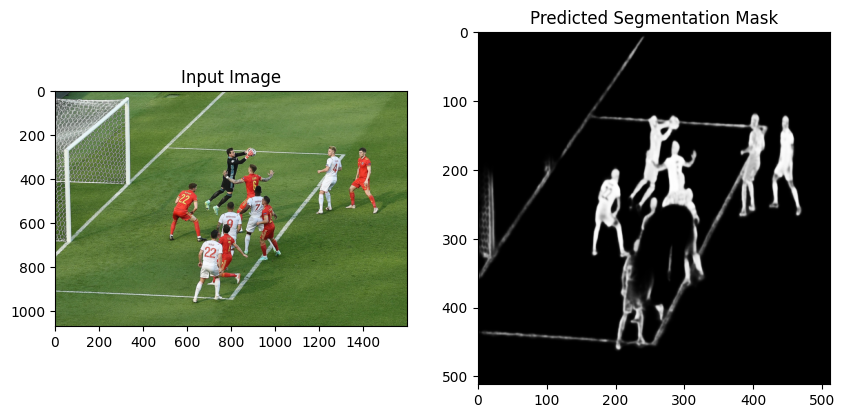

In [30]:
# 4. Convert the Tensor Output to a NumPy Array for Plotting
# The output tensor has shape (1, 1, H, W), so we remove the batch and channel dimensions
output_np = output.squeeze().cpu().numpy()  # Shape becomes (H, W)

# 5. Plot the Original Image and the Predicted Segmentation Mask
plt.figure(figsize=(10, 5))

# Plot the Original Input Image
plt.subplot(1, 2, 1)
img = Image.open(test_image_path)
plt.imshow(img)
plt.title('Input Image')

# Plot the Predicted Segmentation Mask
plt.subplot(1, 2, 2)
plt.imshow(output_np, cmap='gray')  # Display the mask in grayscale
plt.title('Predicted Segmentation Mask')

plt.show()